In [18]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [19]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import pandas as pd

# Load dataset
dataset = fetch_ucirepo(id=17)
X = dataset.data.features
y = dataset.data.targets

# Encode target if necessary (from 'M'/'B' to 1/0)
y = y['Diagnosis'].map({'M': 1, 'B': 0})  # Malignant = 1, Benign = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9766081871345029

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.94      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


Confusion Matrix:
 [[107   0]
 [  4  60]]


C:\Users\etgauthi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [14:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


conformal e-prediction

In [25]:
# binary search parameters
tolerance = 0.005
epsilon = 1e-10

In [ ]:
import numpy as np

# for iteration
proba = 0
alphas_mins = [] # store the true alpha
alpha_loos = [] # store the leave-one-out estimates of alpha
Niter = 200

C = 1 # max target size of the conformal set

for iter in range(Niter):
    print(f"Iteration {iter}")

    X_cal, X_final_test, y_cal, y_final_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=iter
    )   

    X_cal = X_cal.reset_index(drop=True)
    X_final_test = X_final_test.reset_index(drop=True)
    y_cal = y_cal.reset_index(drop=True)
    y_final_test = y_final_test.reset_index(drop=True)

    calibration_scores = [] # store the scores
    calibration_size = len(X_cal)
    final_test_size = len(X_final_test)
    
    y_pred_calib = model.predict_proba(X_cal)[:, 1]
    eps = 1e-15
    y_pred_calib = np.clip(y_pred_calib, eps, 1 - eps)  # numerical stability

    calibration_scores = - (y_cal * np.log(y_pred_calib) + (1 - y_cal) * np.log(1 - y_pred_calib))

    sum_label = sum(calibration_scores)

    # sample one random element from the final test set
    random_idx = np.random.choice(final_test_size) 
    true_label = y_final_test[random_idx]
    y_pred = model.predict_proba(X_final_test.iloc[random_idx,:].values.reshape(1, -1))[:, 1]

    ratios = []
    for k in range(2): 
        S = - (k * np.log(y_pred) + (1 - k) * np.log(1 - y_pred))
        ratio = (calibration_size + 1) * S / (sum_label + S)
        ratios.append(ratio)

    left, right = epsilon, 1.0 - epsilon

    while right - left > tolerance:
        alpha = (left + right) / 2
        threshold = 1 / alpha

        conformal_set = [k for k, ratio in enumerate(ratios) if ratio < threshold]

        if len(conformal_set) <= C:
            right = alpha  # try smaller alpha
        else:
            left = alpha   # need larger alpha

    alpha_min = (left + right) / 2
    alphas_mins.append(alpha_min)
    
    if true_label in conformal_set:
        proba += 1

proba = proba/Niter
alpha_mean = sum(alphas_mins)/Niter 
print(f"Proba = {proba}")
print(f"1-E[alpha] = {1-alpha_mean}")

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

plot

C:\Users\etgauthi\AppData\Local\Temp\ipykernel_33628\2847024568.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


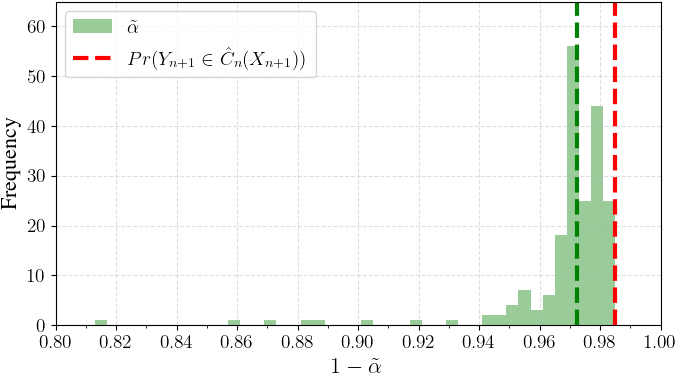

In [ ]:
import matplotlib.pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.icml2024())

# plot histogram of 1-alpha
alphas = np.arange(0.005,0.505,0.004)

fig_alpha, ax_alpha = plt.subplots(figsize=(7, 4)) 
ax_alpha.hist(1-np.array(alphas_mins), color='green',alpha=0.4,bins=1-np.array(alphas[::-1]),align='left',label=r"$\tilde{\alpha}$")
ax_alpha.axvline(x=proba, color='red', linestyle='--', linewidth=3,label=r"$Pr(Y_{n+1} \in \hat{C}_n(X_{n+1}))$")
ax_alpha.axvline(x=np.mean(1-np.array(alphas_mins)), color='green', linestyle='--', linewidth=3)
ax_alpha.set_xlabel(r"$1-\tilde{\alpha}$",fontsize=16)
ax_alpha.set_ylabel("Frequency",fontsize=16)

ax_alpha.set_xlim(0.8,1)
ax_alpha.set_ylim(0,65)

ax_alpha.tick_params(axis='both', labelsize=14)

ax_alpha.set_xticks(np.linspace(0.8, 1.0, 11))
ax_alpha.set_xticks(np.linspace(0.8, 1.0, 21),minor=True)

ax_alpha.grid(True, linestyle="--", alpha=0.4)

plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("plots/binary.pdf", format="pdf", bbox_inches="tight")

plt.show()

standard conformal prediction

In [ ]:
CP_conformal_sets = []

# select fixed coverage level
# alpha = alpha_mean
alpha = 0.02
print(f"Target proba = {1-alpha}")

for iter in range(Niter):
    # print(f"Iteration {iter}")

    X_cal, X_final_test, y_cal, y_final_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=iter
    )   

    X_cal = X_cal.reset_index(drop=True)
    X_final_test = X_final_test.reset_index(drop=True)
    y_cal = y_cal.reset_index(drop=True)
    y_final_test = y_final_test.reset_index(drop=True)

    conformal_set = [] # store the conformal set
    calibration_scores = [] # store the scores

    calibration_size = len(X_cal)
    final_test_size = len(X_final_test)

    y_pred_calib = model.predict_proba(X_cal)[:, 1]
    eps = 1e-15
    y_pred_calib = np.clip(y_pred_calib, eps, 1 - eps)  # numerical stability

    calibration_scores = - (y_cal * np.log(y_pred_calib) + (1 - y_cal) * np.log(1 - y_pred_calib))
    quantile = np.quantile(calibration_scores, np.ceil((1-alpha)*(calibration_size+1))/calibration_size)

    # sample one random element from the final test set
    random_idx = np.random.choice(final_test_size) 
    true_label = y_final_test[random_idx]
    y_pred = model.predict_proba(X_final_test.iloc[random_idx,:].values.reshape(1, -1))[:, 1]

    for k in range(2): 
        S = - (k * np.log(y_pred) + (1 - k) * np.log(1 - y_pred))
        if S <= quantile:
            conformal_set.append(k)
    
    CP_conformal_sets.append(conformal_set)
    
    if true_label in conformal_set:
        proba += 1
        ratios.append(0)
    else:
        ratios.append(1/alpha_min)

proba = proba/Niter

print(f"Proba = {proba}")
print(f"Conformal sets = {CP_conformal_sets}")

c0 = c1 = c2 = 0

for cs in CP_conformal_sets:
    if len(cs) == 0:
        c0 += 1
    elif len(cs) == 1:
        c1 += 1
    elif len(cs) == 2:
        c2 += 1
print("Conformal sets of size:")
print("Size 0:", c0)
print("Size 1:", c1)
print("Size 2:", c2)

Target proba = 0.9722851561555429
Proba = 0.984925
Conformal sets = [[1], [0], [1], [1], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [1], [1], [1], [0], [0], [1], [0], [1], [1], [0], [0], [0], [0], [1], [1], [0], [0], [1], [0], [0], [0], [0], [1], [1], [0], [1], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [1], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [1], [1], [1], [0], [1], [1], [0], [0], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0, 1], [0], [1], [1], [0], [1], [0], [1], [0], [0], [1], [0], [1], [1], [1], [1], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [1], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [0], [0], [0], [1], [0], [0]